## HW4-6
觀察PTT八卦版近2000篇文章的所有留言，探討最近鄉民關心的話題以及八卦版鄉民的素質

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

使用爬蟲爬取ptt web版最近100頁的文章

In [10]:
df = pd.read_json('data/Gossiping-38895-38995.json')

In [176]:
start = datetime.strptime(df.at[0, 'articles']['date'], '%a %b  %d %H:%M:%S %Y')
end = datetime.strptime(df.at[len(df)-1, 'articles']['date'], '%a %b  %d %H:%M:%S %Y')

In [177]:
print('爬取PTT八卦版',datetime.strftime(start, '%Y/%m/%d %H:%M'),'至',datetime.strftime(end, '%Y/%m/%d %H:%M'),'共',len(df),'篇文章')

爬取PTT八卦版 2019/05/05 19:53 至 2019/05/06 17:44 共 1936 篇文章


In [140]:
stopWords = []
with open('data/stopWords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)
stopWords.append(' ')

In [141]:
with open('data/addWords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        jieba.add_word(data)

In [142]:
push_lst = []
for i in range(len(df)):
    for push in df.at[i, 'articles']['messages']:
        push_lst.append(push['push_content'])

In [178]:
print('使用',len(push_lst),'筆留言分析')

使用 68109 筆留言分析


In [143]:
terms=[]
for i in range(len(push_lst)):
    for j in list(jieba.cut(push_lst[i], cut_all = False)):
        if j not in stopWords:
            terms.append(j)

鄉民熱門用語前十名（已去除掉部分無意義的詞）

In [144]:
sorted(Counter(terms).items(), key=lambda x:x[1], reverse=True)[:10]

[('推', 2638),
 ('中國', 2397),
 ('台灣', 2276),
 ('發大財', 1576),
 ('韓粉', 1217),
 ('不要', 994),
 ('幹', 931),
 ('美國', 889),
 ('支那', 732),
 ('XD', 721)]

使用文字雲視覺化這兩天八卦鄉民所關注的議題

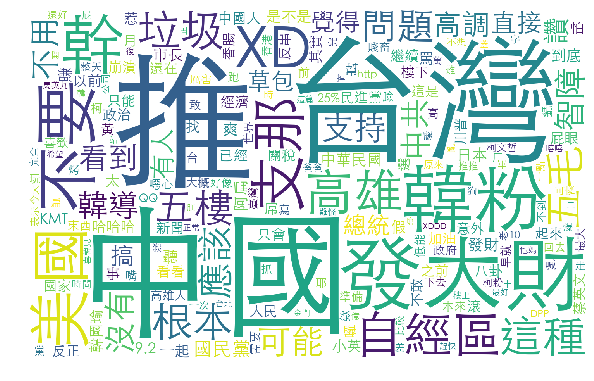

<Figure size 432x288 with 0 Axes>

In [145]:
wc = WordCloud(background_color = "white", width = 1440, height = 900, margin= 2, font_path="STHeiti Light.ttc")
wc.generate_from_frequencies(Counter(terms))
plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()
plt.savefig("文字雲", dpi=100)

雖然名為八卦版，但隨著近年政治議題在鄉民間的討論度逐漸升高，從用文字雲可以看出鄉民非常熱衷政治，遣詞用字都散發憂國憂民的氣息，十分關注美中台三方關係；同時亦十分喜歡討論政治新聞，如近日火熱的自經區、發大財等等

In [146]:
import networkx as nx
import matplotlib.pyplot as plt
import jieba
import codecs
import jieba.posseg as pseg

TDM跑太久，先暫時不使用，可至我的[hw1-3](https://github.com/r05323045/NTU_CSX4001_SPRING_2019/blob/master/hw1-3/hw1-3.ipynb)中觀看TDM的作法

### Co-Occurrence Matrix

In [147]:
names = {}          
relationships = {}  
lineNames = []     

for i in range(len(push_lst)):
    try:
        poss = jieba.cut(push_lst[i], cut_all = False)
        lineNames.append([])
        for w in poss:
            if w not in stopWords:
                lineNames[-1].append(w)        
            if names.get(w) is None and w not in stopWords:
                names[w] = 0
                relationships[w] = {}
                names[w] += 1   
    except:
        pass

for line in lineNames:                  
    for name1 in line:                  
        for name2 in line:             
            if name1 == name2:
                continue
            if relationships[name1].get(name2) is None:     
                relationships[name1][name2]= 1
            else:
                relationships[name1][name2] = relationships[name1][name2]+ 1       

In [148]:
co_occur_by_records = [[name, v, w] for name, edges in relationships.items() for v, w in edges.items() if w > 50]

In [149]:
np.random.shuffle(co_occur_by_records)
temp_matrix = pd.DataFrame()
for i in co_occur_by_records:
    temp_matrix.at[i[0], i[1]] = i[2]
co_occurrence_matrix_by_records = pd.DataFrame()
for i in temp_matrix:
    for j in temp_matrix:
        co_occurrence_matrix_by_records.at[i, j] = temp_matrix.at[i, j]
co_occurrence_matrix_by_records.head()

,推母豬,發大財,母豬,智障,捷神,台灣,關稅,中國,八卦,韓粉,...,五毛,經濟,應該,版,公司,回去,支持,\,屁,賤畜
推母豬,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
發大財,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
母豬,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN
智障,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
捷神,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN


In [150]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
count_by_records = [i[2] for i in co_occur_by_records]
co_occur_by_records_sig = []
for i in co_occur_by_records:
    co_occur_by_records_sig.append([i[0], i[1], sigmoid((i[2] - np.mean(count_by_records))/np.std(count_by_records))])

使用sigmoid函數，將詞頻的高低差距縮小，避免高頻的詞在共線圖中擠在一起

### 共線圖

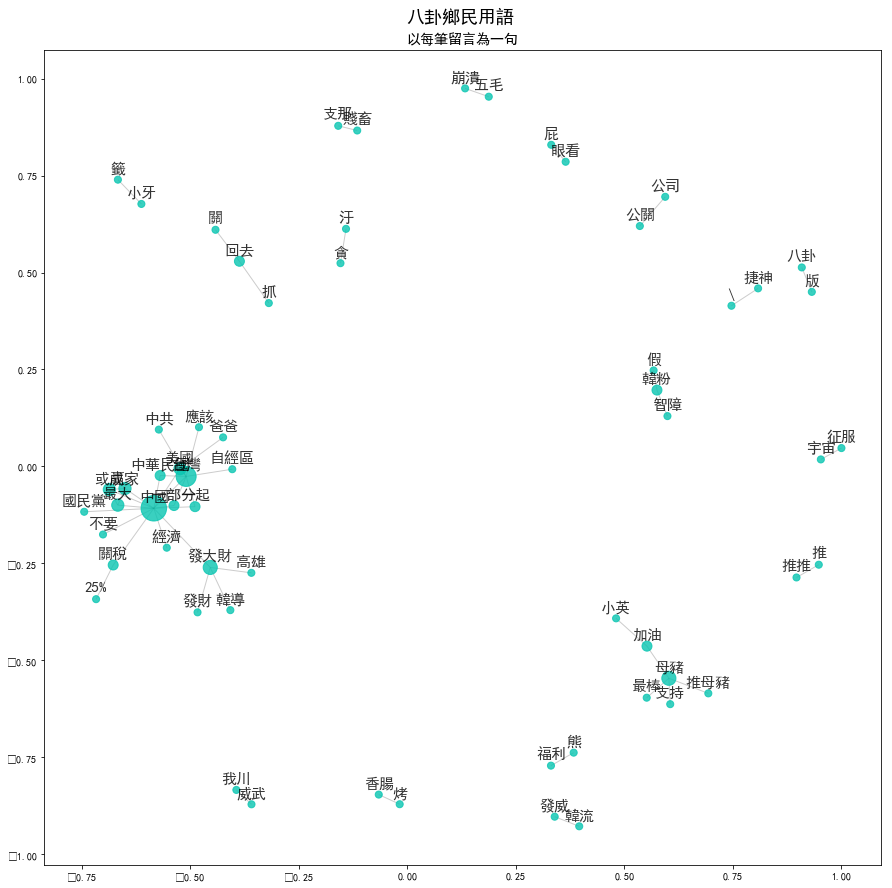

In [157]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_occur_by_records_sig)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*50 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
plt.title('以每筆留言為一句', size = 14)
plt.suptitle('八卦鄉民用語',x = 0.51,y=0.92, fontsize=18)
#plt.savefig("用詞共線圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

從共線圖可以看出近兩天熱門的話題，如中美貿易戰升溫、春吶、高雄議會質詢，甚至可以看出一些鄉民因應時事自創的用語，如我川威武、中國或成最大贏家等

### 熱度圖

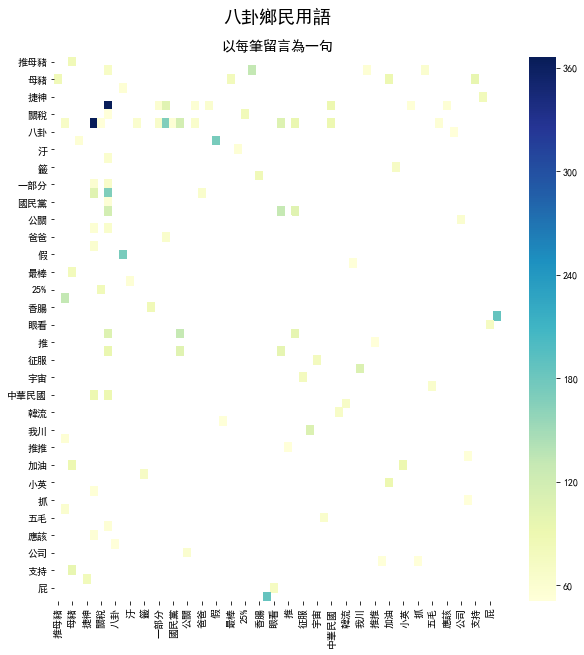

In [158]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(co_occurrence_matrix_by_records,cmap='YlGnBu')
plt.title('以每筆留言為一句', size = 14)
plt.suptitle('八卦鄉民用語',x = 0.435,y=0.95, fontsize=18)
#plt.savefig("images/用詞熱度圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

因此次分析的為用字量較少的推文，且因每篇文章的主題不同，推文的內容也不盡相同，故詞語間較分散，除了特定用語會一起使用外，大部分都豪無關聯